## OpenVINO optimizations for Knowledge graphs 

The goal of this notebook is to showcase performance optimizations for the ConvE knowledge graph embeddings model using the Intel® Distribution of OpenVINO™ Toolkit.
The optimizations process contains the following steps:
1. Train the ConvE model using the countries dataset
2. Export the trained model to OpenVINO intermediate representation (IR)
3. Compare the inference performance with the optimized OpenVINO model

The ConvE model we use is an implementation of the paper Convolutional 2D Knowledge Graph Embeddings (https://arxiv.org/abs/1707.01476). The sample dataset was downloaded from: https://github.com/TimDettmers/ConvE/tree/master/countries/countries_S1

In [1]:
# On Windows, add the directory that contains cl.exe to the PATH to enable PyTorch to find the
# required C++ tools. This code assumes that Visual Studio 2019 is installed in the default
# directory. If you have a different C++ compiler, please add the correct path to os.environ["PATH"]
# directly. Note that the C++ Redistributable is not enough to run this notebook.

# Adding the path to os.environ["LIB"] is not always required - it depends on the system's configuration

import sys

if sys.platform == "win32":
    import distutils.command.build_ext
    import os
    from pathlib import Path

    VS_INSTALL_DIR = r"C:/Program Files (x86)/Microsoft Visual Studio"
    cl_paths = sorted(list(Path(VS_INSTALL_DIR).glob("**/Hostx86/x64/cl.exe")))
    if len(cl_paths) == 0:
        raise ValueError(
            "Cannot find Visual Studio. This notebook requires a C++ compiler. If you installed "
            "a C++ compiler, please add the directory that contains cl.exe to `os.environ['PATH']`."
        )
    else:
        # If multiple versions of MSVC are installed, get the most recent version
        cl_path = cl_paths[-1]
        vs_dir = str(cl_path.parent)
        os.environ["PATH"] += f"{os.pathsep}{vs_dir}"
        # Code for finding the library dirs from
        # https://stackoverflow.com/questions/47423246/get-pythons-lib-path
        d = distutils.core.Distribution()
        b = distutils.command.build_ext.build_ext(d)
        b.finalize_options()
        os.environ["LIB"] = os.pathsep.join(b.library_dirs)
        print(f"Added {vs_dir} to PATH")

In [2]:
import numpy as np 
import torch 
from torch.nn import functional as F, Parameter
from torch.nn.init import xavier_normal_
import math
from tqdm import tqdm
import json
from pathlib import Path
import matplotlib.pyplot as plt
import time

### Settings: Including path to the serialized model files, input data files as well as hyperparameter settings



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

modelpath = Path('models/conve.pt')

entdatapath = Path('data/countries_S1/kg_training_entids.txt')            # Path to the file containing the entities and entity IDs
reldatapath = Path('data/countries_S1/kg_training_relids.txt')            # Path to the file containing the relations and relation IDs
traindatapath = Path('data/countries_S1/e1rel_to_e2_train.json')          # Path to the training data file
testdatapath = Path('data/countries_S1/e1rel_to_e2_ranking_test.json')    # Path to the test data file

batch_size = 1                                                      # Batch size
input_dropout = 0.2                                                 # Input dropout for the model
dropout = 0.3                                                       # Dropout for the model
feature_map_dropout = 0.2                                           # Feature map dropout for the model
use_bias = True 
emb_dim = 300                                                       # Entity and relation embedding dimensions
lr = 0.001                                                          # Learning rate
l2 = 5e-4                                                           # L2 regularization
label_smoothing_epsilon = 0.1                                       # Label smoothing epsilon
max_epochs = 10                                                     # Max epochs

top_k = 2                                                          # Top K vals to consider from the predictions


### Required for OpenVINO conversion
output_dir = Path("models")
base_model_name = "conve"

output_dir.mkdir(exist_ok=True)

# Paths where PyTorch, ONNX and OpenVINO IR models will be stored
fp32_onnx_path = Path(output_dir / (base_model_name + "_fp32")).with_suffix(".onnx")
fp32_ir_path = fp32_onnx_path.with_suffix(".xml")

Using cpu device


### Defining the ConvE model class

In [4]:
class ConvE(torch.nn.Module):
    def __init__(self, num_entities, num_relations):
        super(ConvE, self).__init__()
        # Embedding tables for entity and relations with num_uniq_ent in y-dim, emb_dim in x-dim
        self.emb_e = torch.nn.Embedding(num_entities, emb_dim, padding_idx=0)
        self.ent_weights_matrix = torch.ones([num_entities, emb_dim], dtype=torch.float64)
        self.emb_rel = torch.nn.Embedding(num_relations, emb_dim, padding_idx=0)
        self.ne = num_entities
        self.nr = num_relations
        self.inp_drop = torch.nn.Dropout(input_dropout)
        self.hidden_drop = torch.nn.Dropout(dropout)
        self.feature_map_drop = torch.nn.Dropout2d(feature_map_dropout)
        self.loss = torch.nn.BCELoss()

        self.conv1 = torch.nn.Conv2d(1, 32, (3, 3), 1, 0, bias=use_bias)
        self.bn0 = torch.nn.BatchNorm2d(1)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm1d(emb_dim)
        self.ln0 = torch.nn.LayerNorm(emb_dim)
        self.register_parameter('b', Parameter(torch.zeros(num_entities)))
        self.fc = torch.nn.Linear(16128,emb_dim)
    
    def init(self):
        # Xavier initialization
        xavier_normal_(self.emb_e.weight.data)
        xavier_normal_(self.emb_rel.weight.data)
        
    
    def forward(self, e1, rel, print_pred=False):
        batch_size = 1
        e1_embedded= self.emb_e(e1).view(-1, 1, 10, 30)
        rel_embedded = self.emb_rel(rel).view(-1, 1, 10, 30)
        stacked_inputs = torch.cat([e1_embedded, rel_embedded], 2)

        stacked_inputs = self.bn0(stacked_inputs)
        x= self.inp_drop(stacked_inputs)
        x= self.conv1(x)
        x= self.bn1(x)
        x= F.relu(x)
        x = self.feature_map_drop(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        x = self.hidden_drop(x)
        # Try Layer norm instead of batch norm
        #x = self.bn2(x)
        x = self.ln0(x)
        x = F.relu(x)
        x = torch.mm(x, self.emb_e.weight.transpose(1,0)) # shape (batch, n_ent)
        x = self.hidden_drop(x)
        x += self.b.expand_as(x)
        pred = torch.nn.functional.softmax(x, dim=1)
        #print(pred.shape)
        return pred

### Defining the dataloader

In [5]:
class DataLoader():
    def __init__(self):
        super(DataLoader, self).__init__()
        
        self.ent_path = entdatapath
        self.rel_path = reldatapath
        self.train_file = traindatapath
        self.test_file = testdatapath
        self.entity_ids = self.load_data(self.ent_path) 
        self.ids2entities =  self.id2ent(self.ent_path) 
        self.rel_ids =  self.load_data(self.rel_path)
        self.ids2rel =  self.id2rel(self.rel_path) 
        self.train_triples_list = self.convert_triples(self.train_file)
        self.test_triples_list = self.convert_triples(self.test_file)


    def load_data(self, data_path):
        item_dict = {}
        with open(data_path) as df:
            lines = df.readlines()
            for line in lines:
                name, id = line.strip().split('\t')
                item_dict[name] = int(id)
        return item_dict
    
    def id2ent(self, data_path):
        item_dict = {}
        with open(data_path) as df:
            lines = df.readlines()
            for line in lines:
                name, id = line.strip().split('\t')
                item_dict[int(id)] = name
        return item_dict
    
    def id2rel(self, data_path):
        item_dict = {}
        with open(data_path) as df:
            lines = df.readlines()
            for line in lines:
                name, id = line.strip().split('\t')
                item_dict[int(id)] = name
        return item_dict
    
    def convert_triples(self, data_path):
        triples_list = []
        with open(data_path) as df:
            lines = df.readlines()
            for line in lines:
                item_dict = json.loads(line.strip())
                h = item_dict['e1']
                r = item_dict['rel']
                t = item_dict['e2_multi1'].split('\t')
                hrt_list = []
                hrt_list.append(self.entity_ids[h])
                hrt_list.append(self.rel_ids[r])
                t_ents = []
                for t_idx in t:
                    t_ents.append(self.entity_ids[t_idx])
                hrt_list.append(t_ents)
                triples_list.append(hrt_list)
        return triples_list

### Train the ConvE models

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-6-62475bfa34d2>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = model.loss(logits, torch.tensor(e2_multi))
100%|██████████| 10/10 [02:12<00:00, 13.21s/it]

Finished training the ConvE model


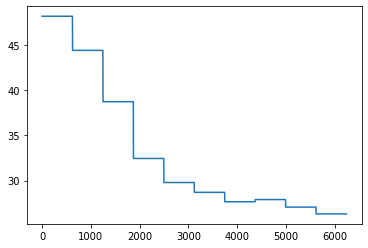

In [6]:
data = DataLoader()
num_entities =  len(data.entity_ids)
num_relations =  len(data.rel_ids)
triples_list = data.train_triples_list
num_train_samples = len(triples_list)
num_train_steps = math.ceil(num_train_samples/int(batch_size))

model = ConvE(num_entities, num_relations)
model.init()
optimizer = torch.optim.Adam(model.parameters())

# Fitting the Model
model.train()
loss_values = []
for ep in tqdm(range(max_epochs)):
    epoch_loss = 0
    # TODO: Check support for higher batch size > 1 training
    for counter in range(num_train_steps):
        optimizer.zero_grad()
        e2_multi = torch.zeros(batch_size, num_entities)
        train_sample = triples_list[counter:counter+int(batch_size)]
        h,r,t = train_sample[0]
        logits = model.forward(torch.tensor(h), torch.tensor(r), print_pred=False)
        for t_id in t:
            e2_multi[0][t_id] = 1.0
        loss = model.loss(logits, torch.tensor(e2_multi))
        loss.backward()
        optimizer.step()
        batch_loss = torch.sum(loss)
        #print('Batch {}: Batch loss:{}'.format(counter, batch_loss))
        epoch_loss += batch_loss
        loss_values.append(epoch_loss)
        counter = counter + int(batch_size)
    #print('Epoch loss:{}'.format(epoch_loss))
print(f'Finished training the ConvE model')
plt.plot(np.array(loss_values))


# Save model    
torch.save(model.state_dict(), modelpath)

### Evaluate the trained ConvE model

In [7]:
data = DataLoader()
num_entities =  len(data.entity_ids)
num_relations =  len(data.rel_ids)

names_dict = data.ids2entities
rel_dict = data.ids2rel

model = ConvE(num_entities, num_relations)
model.load_state_dict(torch.load(modelpath))
model.eval()

inf_times = []

triples_list = data.test_triples_list
num_test_samples = len(triples_list)
for i in range(num_test_samples):
    test_sample = triples_list[i]
    #print('Testing sample:{}'.format(test_sample))
    h,r,t = test_sample
    start_time = time.time()
    logits = model.forward(torch.tensor(h), torch.tensor(r), print_pred=False)
    end_time = time.time()
    inf_times.append(end_time-start_time)
    score, pred = torch.topk(logits, top_k, 1)

    print("--------------------------------------------------------------------------")
    for j, id in enumerate(pred[0].cpu().detach().numpy()): 
        pred_entity = names_dict[id]
        print('Entity:{}, Relation:{}, Model Predictions:{}, Ground truth Target:{}'.format(names_dict[h], rel_dict[r], names_dict[id], names_dict[t[0]]))

print("--------------------------------------------------------------------------")
avg_pt_time = np.mean(inf_times)*1000
print(f'Average time taken for inference: {avg_pt_time} ms')


--------------------------------------------------------------------------
Entity:zambia, Relation:locatedin, Model Predictions:eastern_africa, Ground truth Target:africa
Entity:zambia, Relation:locatedin, Model Predictions:africa, Ground truth Target:africa
--------------------------------------------------------------------------
Entity:morocco, Relation:locatedin, Model Predictions:northern_africa, Ground truth Target:africa
Entity:morocco, Relation:locatedin, Model Predictions:europe, Ground truth Target:africa
--------------------------------------------------------------------------
Entity:san_marino, Relation:locatedin, Model Predictions:southern_europe, Ground truth Target:europe
Entity:san_marino, Relation:locatedin, Model Predictions:europe, Ground truth Target:europe
--------------------------------------------------------------------------
Entity:canada, Relation:locatedin, Model Predictions:northern_america, Ground truth Target:americas
Entity:canada, Relation:locatedin, M

### Convert the trained PyTorch model to ONNX format

In [18]:
print(f'Converting the trained conve model to ONNX format')
torch.onnx.export(model, (torch.tensor(1), torch.tensor(1)), fp32_onnx_path, verbose=False, opset_version=11, training=False)

Converting the trained conve model to ONNX format


### Convert the ONNX model to OpenVINO format

In [32]:
if not fp32_ir_path.exists():
    !mo --input_model "$fp32_onnx_path" --input='input.1[1],input.2[1]' --data_type FP32 --output_dir "$output_dir"
    assert fp32_ir_path.exists(), "The IR of FP32 model wasn't created"

### Benchmark the converted OpenVINO model using benchmark app

In [33]:
def parse_benchmark_output(benchmark_output: str):
    """Prints the output from benchmark_app in human-readable format"""
    parsed_output = [line for line in benchmark_output if not (line.startswith(r"[") or line.startswith("  ") or line == "")]
    print(*parsed_output, sep='\n')
    avg_latency_str = [line for line in benchmark_output if ("AVG" in line)]
    avg_ov_latency = float(avg_latency_str[0].strip().split('AVG')[1].split('ms')[0].split(':')[1].strip())
    print(f'Avg OV latency: {avg_ov_latency} ms')
    return avg_ov_latency


print('Benchmark FP32 model (IR)')
benchmark_output = ! benchmark_app -m "$fp32_ir_path" -d CPU -api async -t 15 -shape 'input.1[1],input.2[1]'
avg_ov_latency = parse_benchmark_output(benchmark_output)
print(f'Speedup with OV optimizations: {round(float(avg_pt_time)/float(avg_ov_latency),2)} X')



Benchmark FP32 model (IR)
Count:          448356 iterations
Duration:       15000.52 ms
Latency:
Throughput: 29889.35 FPS
Avg OV latency: 0.35 ms
Speedup with OV optimizations: 6.69 X
